# **Facial Emotion Detection - Final Code**

## **Problem Definition**
<br>
Human Emotion detection from an image is one of the most powerful and challenging research tasks in social communication. Users are more efficient in emotion-sensitive Human-Computer Interaction (HCI) systems. The face is the most expressive and communicative portion of a human. <br>
In psychology, interpreting facial expressions can provide valuable insights into the emotional states and experiences of individuals. In marketing, facial expression recognition can be used to analyze consumer emotions and behavior in response to products, advertisements, and brand experiences. Facial expression recognition has also been applied in other fields, such as security, law enforcement, and robotics. For example, security systems that use facial expression recognition can alert authorities to potential threats based on the emotional states of individuals.<br><br>

**Objectives**<br>

In this project, our goal is not only to better understand and improve the performance of emotion recognition models but also to apply them to real-world data sets. Here we aim to develop a deep learning model that can categorize facial emotions into 4 categories, namely happy, sad, neutral, and surprised.<br><br>

## **About the dataset**

The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'. 
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>



## **Mounting the Drive**


In [1]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the Libraries**

In [2]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
import random
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model


import tensorflow.keras.applications as ap
from tensorflow.keras import Model

from tabulate import tabulate


### **loading the data**

In [3]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Facial_emotion_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
picture_size = 48
folder_path = "Facial_emotion_images/"

## **Visualizing our Classes**

Let's look at our classes. 

### **Happy**

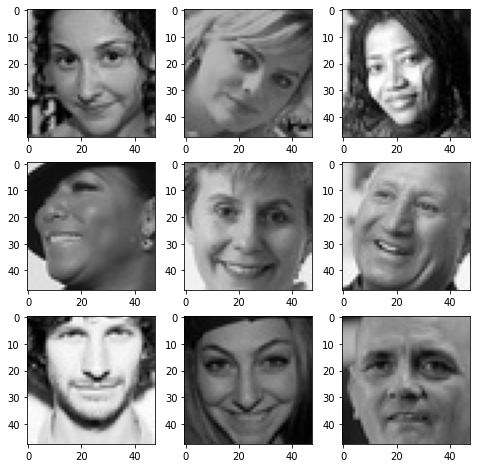

In [5]:
expression = 'happy'
plt.figure(figsize= (8,8))
img_path=folder_path + "train/" + expression;
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img(img_path + "/" + os.listdir(img_path)[i], target_size = (picture_size, picture_size))
    plt.imshow(img)   

plt.show()

### **Sad**

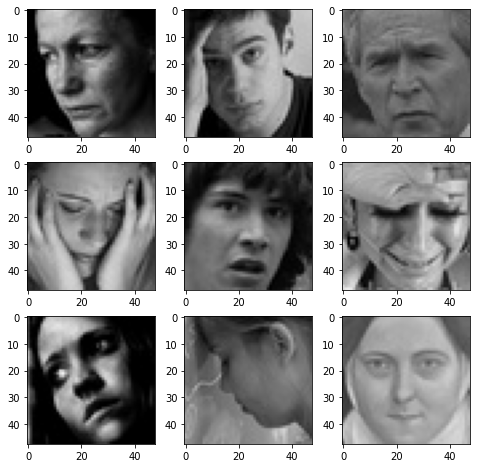

In [6]:
expression = 'sad'
plt.figure(figsize= (8,8))
img_path=folder_path + "train/" + expression;
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img(img_path + "/" + os.listdir(img_path)[i], target_size = (picture_size, picture_size))
    plt.imshow(img)   

plt.show()

### **Neutral**

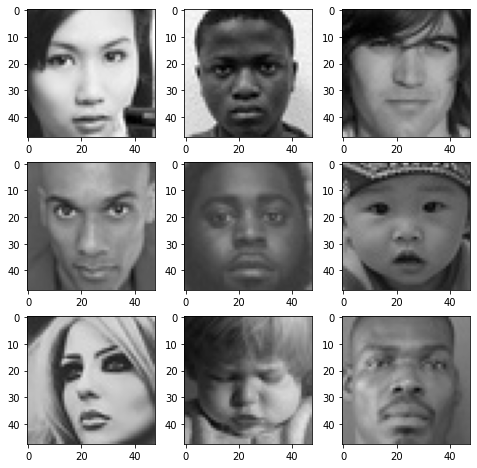

In [7]:
expression = 'neutral'
plt.figure(figsize= (8,8))
img_path=folder_path + "train/" + expression;
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img(img_path + "/" + os.listdir(img_path)[i], target_size = (picture_size, picture_size))
    plt.imshow(img)   

plt.show()

### **Surprised**

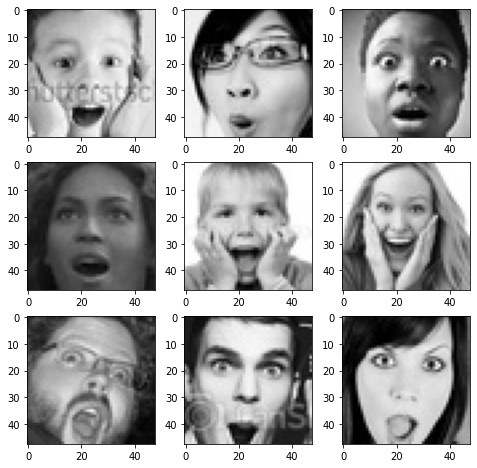

In [8]:
expression = 'surprise'
plt.figure(figsize= (8,8))
img_path=folder_path + "train/" + expression;
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img(img_path + "/" + os.listdir(img_path)[i], target_size = (picture_size, picture_size))
    plt.imshow(img)   

plt.show()

### **Observations**<br>

Looking at the data, there are some specific features associated with each class such as the form of the mouth, eyes, etc. These distinctive features are more dominant for happy and surprised categories and more subtle for angry and neutral. In fact, the last two categories are so close in some cases that it makes it hard for even human eyes to distinguish between them. <br><hr>  

## **Checking Distribution of Classes**

In [ ]:
# Getting count of images in each folder within our training path
num_happy = len(os.listdir(folder_path + "train/happy"))
print("Number of images in the class 'happy':   ", num_happy)

num_sad = len(os.listdir(folder_path + "train/sad"))
print("Number of images in the class 'sad':   ", num_sad)

num_neutral = len(os.listdir(folder_path + "train/neutral"))
print("Number of images in the class 'neutral':   ", num_neutral)

num_surprise = len(os.listdir(folder_path + "train/surprise"))
print("Number of images in the class 'surprise':   ", num_surprise)

Number of images in the class 'happy':    3976
Number of images in the class 'sad':    3982
Number of images in the class 'neutral':    3978
Number of images in the class 'surprise':    3173


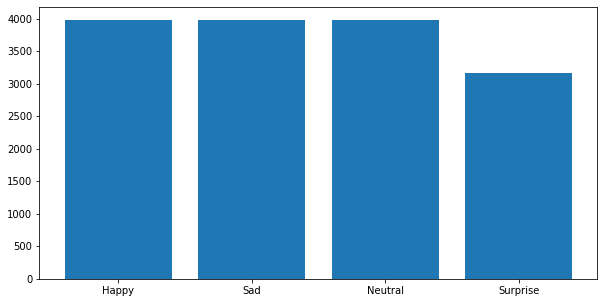

In [ ]:
# Code to plot histogram
plt.figure(figsize = (10, 5))

plt.bar(["Happy", "Sad", "Neutral", "Surprise"],[num_happy,num_sad,num_neutral,num_surprise])

plt.show()

### **Observations:**<br>
Happy, sad, and neutral categories  have around the same number of data. The surprise category, however, has a slightly lower number of instances.<br>
An imbalance in a CNN could result in poor performance for the class with less representation, impacting overall performance. On the other hand, Surprise photos were very distinctive from the other categories because of their bold features. Therefore, it's unlikely that the imbalance would cause serious issues.<br><hr>

## **Solution Approach**
 

1.   We start by building 3 models from scratch. Each time we increase the complexity of the models and assess their performance  on the validation set.
2.   Next, we'll use transfer learning to see if the popular trained models can be helpful
3.  Finally, we'll try to further improve the models, maximize the accuracy and select the best one.
  

## **Creating our Data Loaders**
**Note**<br>
Data augmentation is a useful technique to increase  the size of training data and add more variety to it. Here we only apply the augmentation to the training data since having augmentation on the validation or test sets isn't quite meaningful.

In [ ]:
batch_size  = 32
img_size = 48
color_mode='grayscale'

if color_mode=='grayscale':
    N_channel=1
elif color_mode=='rgb':
    N_channel=3

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = color_mode ,
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)


datagen_test_val = ImageDataGenerator(rescale=1./255)


validation_set = datagen_test_val.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = color_mode ,
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = False)


test_set = datagen_test_val.flow_from_directory(folder_path + "test",
                                              target_size = (img_size, img_size),
                                              color_mode = color_mode ,
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = False)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


### **Creating the Base Neural Network (Model 1)**

**Fixing the random seed to increase reproducibility**

In [ ]:
np.random.seed(10)
random.seed(10)
tf.random.set_seed(10)

Our Base Neural network will be a fairly simple model architecture.

* We want our Base Neural Network architecture to have 3 convolutional blocks.
* First Conv2D layer with **64 filters** and a **kernel size of 2**. with **'relu' activation**.
* MaxPooling2D layer with **pool size = 2**.
* Dropout layer with a dropout ratio of 0.2.
* A second Conv2D layer with **32 filters** and a **kernel size of 2** with the **'same' padding** and **'relu' activation.**
* Following up with a similar Maxpooling2D layer like above and a Dropout layer with 0.2 Dropout ratio to complete our second Convolutional Block.
* A third Conv2D layer with **32 filters** and a **kernel size of 2**. Useing the **'same' padding** and **'relu' activation.** Once again, following it up with a Maxpooling2D layer and a Dropout layer to complete our third Convolutional block.
* A Flatten layer.
* The first Dense layer with **512 neurons** with **'relu' activation function**.
* A Dropout layer with dropout ratio of 0.4.
* Adding a final Dense Layer with 4 neurons and **'softmax' activation function**

In [ ]:
# Initializing a Sequential Model

model1 = Sequential()

# Adding the first Convolutional block

model1.add(Conv2D(filters = 64, kernel_size=(2,2), activation='relu', padding='same', input_shape=(picture_size,picture_size,N_channel)))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(rate=0.2))

# Adding the second Convolutional block

model1.add(Conv2D(filters = 32, kernel_size=(2,2), activation='relu', padding='same'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(rate=0.2))

# Adding the third Convolutional block

model1.add(Conv2D(filters = 32, kernel_size=(2,2), activation='relu', padding='same'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(rate=0.2))

# Adding the flatten layer

model1.add(Flatten())

# Adding the dense layers

model1.add(Dense(512, activation="relu"))
model1.add(Dropout(rate=0.4))
model1.add(Dense(256, activation="relu"))
model1.add(Dense(4, activation="softmax"))

# Printing the model summary
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 32)        8224      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 12, 12, 32)       

### **Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model1.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]


In [ ]:
# Compiling the model 
model1.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Fitting the model

history = model1.fit(train_set, batch_size=128, epochs=20, validation_data= validation_set, callbacks=callbacks_list)

Epoch 1/20
472/473 [============================>.] - ETA: 0s - loss: 1.3779 - accuracy: 0.2738

473/473 [==============================] - 17s 34ms/step - loss: 1.3779 - accuracy: 0.2738 - val_loss: 1.3097 - val_accuracy: 0.3490 - lr: 0.0010
Epoch 2/20
472/473 [============================>.] - ETA: 0s - loss: 1.2687 - accuracy: 0.4075

473/473 [==============================] - 16s 33ms/step - loss: 1.2683 - accuracy: 0.4076 - val_loss: 1.1611 - val_accuracy: 0.4913 - lr: 0.0010
Epoch 3/20
472/473 [============================>.] - ETA: 0s - loss: 1.1850 - accuracy: 0.4577

473/473 [==============================] - 16s 33ms/step - loss: 1.1848 - accuracy: 0.4577 - val_loss: 1.0616 - val_accuracy: 0.5495 - lr: 0.0010
Epoch 4/20
472/473 [============================>.] - ETA: 0s - loss: 1.1377 - accuracy: 0.4931

473/473 [==============================] - 16s 33ms/step - loss: 1.1376 - accuracy: 0.4932 - val_loss: 1.0370 - val_accuracy: 0.5550 - lr: 0.0010
Epoch 5/20
472/473 [============================>.] - ETA: 0s - loss: 1.0971 - accuracy: 0.5177

473/473 [==============================] - 16s 33ms/step - loss: 1.0971 - accuracy: 0.5177 - val_loss: 1.0198 - val_accuracy: 0.5560 - lr: 0.0010
Epoch 6/20
472/473 [============================>.] - ETA: 0s - loss: 1.0721 - accuracy: 0.5302

473/473 [==============================] - 16s 33ms/step - loss: 1.0717 - accuracy: 0.5304 - val_loss: 0.9356 - val_accuracy: 0.6056 - lr: 0.0010
Epoch 7/20
472/473 [============================>.] - ETA: 0s - loss: 1.0424 - accuracy: 0.5388

473/473 [==============================] - 16s 33ms/step - loss: 1.0424 - accuracy: 0.5388 - val_loss: 0.9482 - val_accuracy: 0.6024 - lr: 0.0010
Epoch 8/20
472/473 [============================>.] - ETA: 0s - loss: 1.0230 - accuracy: 0.5504

473/473 [==============================] - 16s 33ms/step - loss: 1.0237 - accuracy: 0.5503 - val_loss: 0.9000 - val_accuracy: 0.6128 - lr: 0.0010
Epoch 9/20
472/473 [============================>.] - ETA: 0s - loss: 1.0086 - accuracy: 0.5644

473/473 [==============================] - 16s 35ms/step - loss: 1.0085 - accuracy: 0.5644 - val_loss: 0.8934 - val_accuracy: 0.6213 - lr: 0.0010
Epoch 10/20
472/473 [============================>.] - ETA: 0s - loss: 0.9940 - accuracy: 0.5652

473/473 [==============================] - 16s 33ms/step - loss: 0.9940 - accuracy: 0.5654 - val_loss: 0.8826 - val_accuracy: 0.6215 - lr: 0.0010
Epoch 11/20
472/473 [============================>.] - ETA: 0s - loss: 0.9801 - accuracy: 0.5740

473/473 [==============================] - 16s 33ms/step - loss: 0.9797 - accuracy: 0.5743 - val_loss: 0.8437 - val_accuracy: 0.6458 - lr: 0.0010
Epoch 12/20
472/473 [============================>.] - ETA: 0s - loss: 0.9638 - accuracy: 0.5852

473/473 [==============================] - 16s 34ms/step - loss: 0.9637 - accuracy: 0.5851 - val_loss: 0.8500 - val_accuracy: 0.6456 - lr: 0.0010
Epoch 13/20
472/473 [============================>.] - ETA: 0s - loss: 0.9565 - accuracy: 0.5867

473/473 [==============================] - 16s 33ms/step - loss: 0.9561 - accuracy: 0.5869 - val_loss: 0.9051 - val_accuracy: 0.6243 - lr: 0.0010
Epoch 14/20
472/473 [============================>.] - ETA: 0s - loss: 0.9471 - accuracy: 0.5920

473/473 [==============================] - 16s 33ms/step - loss: 0.9464 - accuracy: 0.5922 - val_loss: 0.8226 - val_accuracy: 0.6518 - lr: 0.0010
Epoch 15/20
472/473 [============================>.] - ETA: 0s - loss: 0.9340 - accuracy: 0.6014

473/473 [==============================] - 16s 33ms/step - loss: 0.9339 - accuracy: 0.6014 - val_loss: 0.8118 - val_accuracy: 0.6554 - lr: 0.0010
Epoch 16/20
473/473 [==============================] - ETA: 0s - loss: 0.9246 - accuracy: 0.6058

473/473 [==============================] - 16s 34ms/step - loss: 0.9246 - accuracy: 0.6058 - val_loss: 0.8273 - val_accuracy: 0.6504 - lr: 0.0010
Epoch 17/20
472/473 [============================>.] - ETA: 0s - loss: 0.9156 - accuracy: 0.6091

473/473 [==============================] - 16s 33ms/step - loss: 0.9151 - accuracy: 0.6093 - val_loss: 0.8235 - val_accuracy: 0.6556 - lr: 0.0010
Epoch 18/20
472/473 [============================>.] - ETA: 0s - loss: 0.9064 - accuracy: 0.6119Restoring model weights from the end of the best epoch: 15.



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
473/473 [==============================] - 15s 33ms/step - loss: 0.9061 - accuracy: 0.6122 - val_loss: 0.8168 - val_accuracy: 0.6596 - lr: 0.0010
Epoch 18: early stopping


### **Evaluating Model 1 on the validation set**

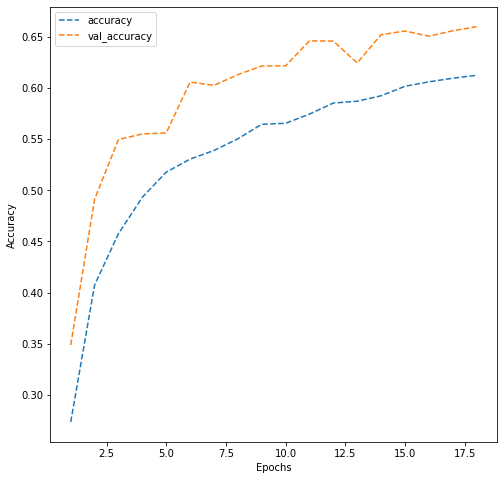

156/156 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

           0       0.79      0.72      0.75      1825
           1       0.54      0.63      0.58      1216
           2       0.52      0.52      0.52      1139
           3       0.79      0.74      0.76       797

    accuracy                           0.66      4977
   macro avg       0.66      0.65      0.65      4977
weighted avg       0.67      0.66      0.66      4977



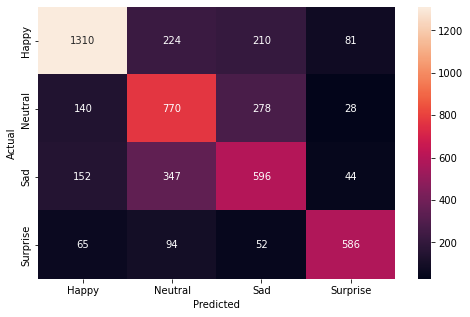

In [ ]:
# Ploting training information

dict_hist = history.history

ne=len(history.history['accuracy'])

list_ep = [i for i in range(1, ne+1)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, history.history['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, history.history['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

# Evaluating the model on the test data

validation_pred = np.argmax(model1.predict(validation_set), axis = 1)

classes = ["Happy", "Neutral", "Sad", "Surprise"]

print(classification_report(validation_set.labels, validation_pred))
cm = confusion_matrix(validation_set.labels, validation_pred)
P_model1=(cm.diagonal()/cm.sum(axis=1)).mean()

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = classes, yticklabels = classes)

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

### **Creating the second Convolutional Neural Network (Model 2)**

**Fixing the random seed to increase reproducibility**

In [ ]:
np.random.seed(10)
random.seed(10)
tf.random.set_seed(10)

In the second Neural network, we will add a few more Convolutional blocks. We will also use Batch Normalization layers.

* This time, each Convolutional block will have 1 Conv2D layer, followed by a BatchNormalization, LeakuRelU, and a MaxPooling2D layer. We are not adding any Dropout layer this time.
* Add first Conv2D layer with **256 filters** and a **kernel size of 2**. Use the 'same' padding and provide the **input_shape = (48, 48, 3) if you are using 'rgb' color mode in your dataloader or else input shape = (48, 48, 1) if you're using 'grayscale' colormode**. Use **'relu' activation**.
* Add your BatchNormalization layer followed by a LeakyRelU layer with Leaky ReLU parameter of **0.1**
* Add MaxPooling2D layer with **pool size = 2**.
* Add a second Conv2D layer with **128 filters** and a **kernel size of 2**. Use the **'same' padding** and **'relu' activation.**
* Follow this up with a similar BatchNormalization, LeakyRelU, and Maxpooling2D layer like above to complete your second Convolutional Block.
* Add a third Conv2D layer with **64 filters** and a **kernel size of 2**. Use the **'same' padding** and **'relu' activation.** Once again, follow it up with a BatchNormalization, LeakyRelU, and Maxpooling2D layer to complete your third Convolutional block.
* Add a fourth block, with the Conv2D layer having **32 filters**.
* After adding your convolutional blocks, add your Flatten layer.
* Add your first Dense layer with **512 neurons**. Use **'relu' activation function**.
* Add the second Dense Layer with **128 neurons** and use **'relu' activation** function.
* Add your final Dense Layer with 4 neurons and **'softmax' activation function**
* Print your model summary

In [ ]:
# Creating sequential model
model2 = Sequential()

# Add the first Convolutional block

model2.add(Conv2D(filters = 256, kernel_size=(2,2), activation='relu', padding='same', input_shape=(picture_size,picture_size,N_channel)))
model2.add(BatchNormalization())
model2.add(LeakyReLU(0.1))
model2.add(MaxPooling2D(pool_size = (2, 2)))

# Add the second Convolutional block

model2.add(Conv2D(filters = 128, kernel_size=(2,2), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(LeakyReLU(0.1))
model2.add(MaxPooling2D(pool_size = (2, 2)))

# Add the third Convolutional block

model2.add(Conv2D(filters = 64, kernel_size=(2,2), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(LeakyReLU(0.1))
model2.add(MaxPooling2D(pool_size = (2, 2)))

# Add the foth Convolutional block

model2.add(Conv2D(filters = 32, kernel_size=(2,2), activation='relu', padding='same'))

# Add the Flatten layer

model2.add(Flatten())

# Adding the Dense layers

model2.add(Dense(512, activation="relu"))
model2.add(Dense(128, activation="relu"))
model2.add(Dense(4, activation="softmax"))



model2.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 256)       1280      
                                                                 
 batch_normalization_15 (Bat  (None, 48, 48, 256)      1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 256)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 128)       131200    
                                                                 
 batch_normalization_16 (Bat  (None, 24, 24, 128)     

### **Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model2.h5", monitor='val_loss', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]


In [ ]:
# Compiling the model  
model2.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
history = model2.fit(train_set, batch_size=32, epochs=20, validation_data= validation_set , callbacks=callbacks_list)

Epoch 1/20
473/473 [==============================] - ETA: 0s - loss: 1.2382 - accuracy: 0.4296
Epoch 1: val_loss improved from -inf to 1.24284, saving model to ./model2.h5
473/473 [==============================] - 18s 37ms/step - loss: 1.2382 - accuracy: 0.4296 - val_loss: 1.2428 - val_accuracy: 0.4227 - lr: 0.0010
Epoch 2/20
472/473 [============================>.] - ETA: 0s - loss: 1.0294 - accuracy: 0.5453
Epoch 2: val_loss did not improve from 1.24284
473/473 [==============================] - 16s 34ms/step - loss: 1.0294 - accuracy: 0.5450 - val_loss: 1.0928 - val_accuracy: 0.5101 - lr: 0.0010
Epoch 3/20
472/473 [============================>.] - ETA: 0s - loss: 0.9510 - accuracy: 0.5870
Epoch 3: val_loss did not improve from 1.24284
473/473 [==============================] - 16s 34ms/step - loss: 0.9511 - accuracy: 0.5870 - val_loss: 0.8857 - val_accuracy: 0.6239 - lr: 0.0010
Epoch 4/20
473/473 [==============================] - ETA: 0s - loss: 0.8812 - accuracy: 0.6178
Epoch 4

### **Evaluating Model 2 on the validation set**

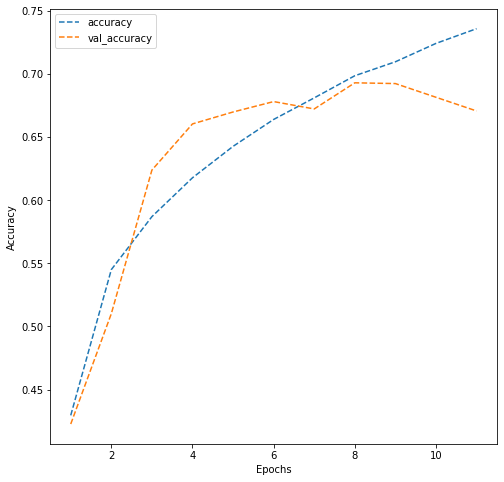

156/156 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1825
           1       0.61      0.53      0.57      1216
           2       0.58      0.63      0.60      1139
           3       0.72      0.85      0.78       797

    accuracy                           0.69      4977
   macro avg       0.68      0.69      0.68      4977
weighted avg       0.69      0.69      0.69      4977



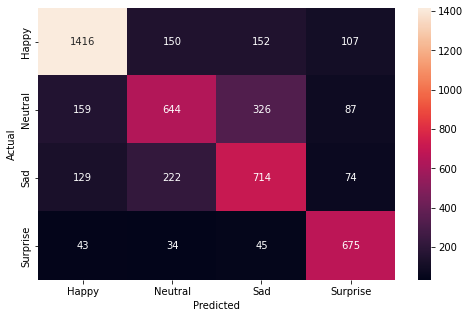

In [ ]:
# Ploting training information

dict_hist = history.history

ne=len(history.history['accuracy'])

list_ep = [i for i in range(1, ne+1)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, history.history['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, history.history['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

# Evaluating the model on the test data

validation_pred = np.argmax(model2.predict(validation_set), axis = 1)

classes = ["Happy", "Neutral", "Sad", "Surprise"]

print(classification_report(validation_set.labels, validation_pred))
cm = confusion_matrix(validation_set.labels, validation_pred)
P_model2=(cm.diagonal()/cm.sum(axis=1)).mean()

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = classes, yticklabels = classes)

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

## **Building a Complex Neural Network Architecture (Model 3)**

**Fixing the random seed to increase reproducibility**

In [ ]:
np.random.seed(10)
random.seed(10)
tf.random.set_seed(10)

### **Model Building**

* In this network, we plan to have 5 Convolutional Blocks
* Add first Conv2D layer with **64 filters** and a **kernel size of 2**. Use the 'same' padding and provide the **input shape = (48, 48, 1)**. Use **'relu' activation**.
* Add your BatchNormalization layer followed by a LeakyRelU layer with Leaky ReLU parameter of **0.1**
* Add MaxPooling2D layer with **pool size = 2**.
* Add a Dropout layer with a Dropout Ratio of **0.2**. This completes the first Convolutional block.
* Add a second Conv2D layer with **128 filters** and a **kernel size of 2**. Use the **'same' padding** and **'relu' activation.**
* Follow this up with a similar BatchNormalization, LeakyRelU, Maxpooling2D, and Dropout layer like above to complete your second Convolutional Block.
* Add a third Conv2D layer with **512 filters** and a **kernel size of 2**. Use the **'same' padding** and **'relu' activation.** Once again, follow it up with a BatchNormalization, LeakyRelU, Maxpooling2D, and Dropout layer to complete your third Convolutional block.
* Add a fourth block, with the Conv2D layer having **512 filters**.
* Add the fifth block, having **128 filters**.
* Then add your Flatten layer, followed by your Dense layers.
* Add your first Dense layer with **256 neurons** followed by a BatchNormalization layer, a **'relu'** Activation, and a Dropout layer. This forms your first Fully Connected block
* Add your second Dense layer with **512 neurons**, again followed by a BatchNormalization layer, **relu** activation, and a Dropout layer.
* Add your final Dense layer with 4 neurons.
* Compile your model with the optimizer of your choice.

In [ ]:
model3 = Sequential()

# Add the first Convolutional block

model3.add(Conv2D(filters = 64, kernel_size=(2,2), activation='relu', padding='same', input_shape=(48,48,1)))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Dropout(rate=0.2))

# Add the second Convolutional block

model3.add(Conv2D(filters = 128, kernel_size=(2,2), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Dropout(rate=0.2))

# Add the third Convolutional block

model3.add(Conv2D(filters = 512, kernel_size=(2,2), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Dropout(rate=0.2))

# Add 4th CNN Block

model3.add(Conv2D(filters = 512, kernel_size=(2,2), activation='relu', padding='same'))

# Add 5th CNN Block

model3.add(Conv2D(filters = 128, kernel_size=(2,2), activation='relu', padding='same'))


model3.add(Flatten())

model3.add(Dense(256, activation="relu"))
model3.add(BatchNormalization())
model3.add(Dropout(rate=0.2))

model3.add(Dense(256, activation="relu"))
model3.add(BatchNormalization())
model3.add(Dropout(rate=0.2))


model3.add(Dense(4, activation = 'softmax'))

### **Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

steps_per_epoch = train_set.n//train_set.batch_size
validation_steps = validation_set.n//validation_set.batch_size

checkpoint = ModelCheckpoint("model3.h5", monitor = 'val_accuracy',
                            save_weights_only = True, model = 'max', verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.0001 , model = 'auto')

callbacks = [checkpoint, reduce_lr]

In [ ]:
# Write your code to compile your model3. Use categorical crossentropy as the loss function, Adam Optimizer with 0.003 learning rate, and set metrics to 'accuracy'.

model3.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [ ]:
# Write your code to fit your model. Use train_set as the training data and validation_set as the validation data. Train your model for 35 epochs.
history = model3.fit(train_set, epochs=35, validation_data= validation_set , callbacks=callbacks_list)

Epoch 1/35
472/473 [============================>.] - ETA: 0s - loss: 1.5208 - accuracy: 0.3041
Epoch 1: val_loss improved from 1.24284 to 2.06075, saving model to ./model2.h5
473/473 [==============================] - 18s 36ms/step - loss: 1.5213 - accuracy: 0.3041 - val_loss: 2.0608 - val_accuracy: 0.2451 - lr: 0.0010
Epoch 2/35
473/473 [==============================] - ETA: 0s - loss: 1.2827 - accuracy: 0.4177
Epoch 2: val_loss did not improve from 2.06075
473/473 [==============================] - 16s 34ms/step - loss: 1.2827 - accuracy: 0.4177 - val_loss: 1.3310 - val_accuracy: 0.4304 - lr: 0.0010
Epoch 3/35
472/473 [============================>.] - ETA: 0s - loss: 1.1404 - accuracy: 0.4944
Epoch 3: val_loss did not improve from 2.06075
473/473 [==============================] - 16s 34ms/step - loss: 1.1404 - accuracy: 0.4943 - val_loss: 1.0172 - val_accuracy: 0.5457 - lr: 0.0010
Epoch 4/35
472/473 [============================>.] - ETA: 0s - loss: 1.0855 - accuracy: 0.5233
Epoc

### **Evaluating Model 3 on the Validation Set**

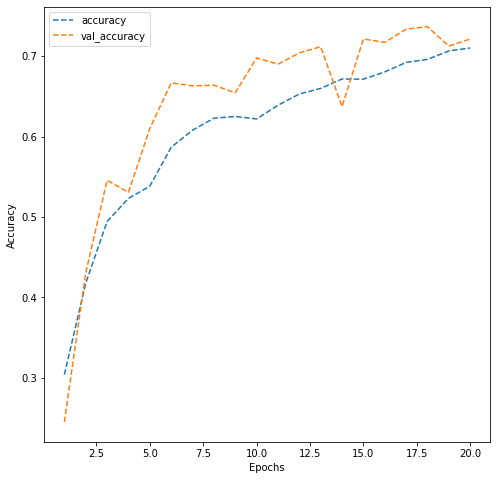

156/156 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1825
           1       0.62      0.70      0.66      1216
           2       0.66      0.56      0.61      1139
           3       0.77      0.84      0.81       797

    accuracy                           0.73      4977
   macro avg       0.72      0.73      0.72      4977
weighted avg       0.74      0.73      0.73      4977



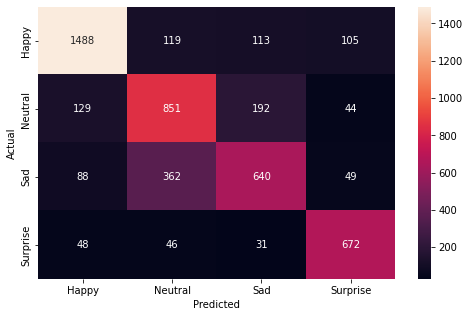

In [ ]:
dict_hist = history.history

ne=len(history.history['accuracy'])

list_ep = [i for i in range(1, ne+1)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, history.history['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, history.history['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

# Evaluating the model on the test data

validation_pred = np.argmax(model3.predict(validation_set), axis = 1)

classes = ["Happy", "Neutral", "Sad", "Surprise"]

print(classification_report(validation_set.labels, validation_pred))
cm = confusion_matrix(validation_set.labels, validation_pred)
P_model3=(cm.diagonal()/cm.sum(axis=1)).mean()
plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = classes, yticklabels = classes)

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

### **Models 1 to 3 Summary and Conclusions**

In [ ]:
data = [["Model 1", P_model1], 
        ["Model 2", P_model2], 
        ["Model 3", P_model3]]
  
#define header names
col_names = ["Model", "Average Precision"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═════════╤═════════════════════╕
│ Model   │   Average Precision │
╞═════════╪═════════════════════╡
│ Model 1 │            0.652389 │
├─────────┼─────────────────────┤
│ Model 2 │            0.694822 │
├─────────┼─────────────────────┤
│ Model 3 │            0.730059 │
╘═════════╧═════════════════════╛


### **Conclusions**



1.   So far, we have trained 3 models with different levels of complexity
2.   In model 1, the validation error is higher than the training set. This is most likely because of too many dropouts that we've used in this model.
3.   Model 2: The model starts to overfit after approx. 10 epochs. 
4.   The accuracy of the models is tabulated in the table above. Model 3 with 73% precision on the validation set is the best model among these three. 
5.  As expected, the majority of the misclassifications occurred between sad and neutral categories as they look very similar in some cases. 

<hr>

## **Transfer Learing**

Here we'll try three popular models, namely, VGG16, ResNet v2, and EfficientNet to build CNN architectures.

## **Creating our Data Loaders**
**Note**<br>
Since our transfer learning models work only with input data with 3 cahnnels, we'll use "rgb" data augmentation to creat 3 channels.

In [7]:
batch_size  = 32
img_size = 48
color_mode='rgb'

if color_mode=='grayscale':
    N_channel=1
elif color_mode=='rgb':
    N_channel=3

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = color_mode ,
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)


datagen_test_val = ImageDataGenerator(rescale=1./255)


validation_set = datagen_test_val.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = color_mode ,
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = False)


test_set = datagen_test_val.flow_from_directory(folder_path + "test",
                                              target_size = (img_size, img_size),
                                              color_mode = color_mode ,
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = False)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **VGG16 Model**

**Fixing the random seed to increase reproducibility**

In [ ]:
np.random.seed(10)
random.seed(10)
tf.random.set_seed(10)

### **Importing the VGG16 Architecture**

In [ ]:
vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (48, 48, 3))
vgg.summary()
print("\n The number of layers in VGG16 is: ",len(vgg.layers))

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

### **Model Building**

* In this model, we will import till the **'block5_pool'** layer of the VGG16 model.

In [ ]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable=False


# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer.output)

# Adding a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.3)(x)

# Add a Dense Layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
# Add a Dense Layer with 64 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Batch Normalization layer

x = BatchNormalization()(x)
# Adding the final dense layer with 4 neurons and use 'softmax' activation
pred = Dense(4, activation='softmax')(x)

vggmodel = Model(vgg.input, pred) # Initializing the model

### **Compiling and Training the VGG16 Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./vggmodel.h5", monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.5,
                              patience = 5,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [ ]:
# Write your code to compile the vggmodel. Use categorical crossentropy as the loss function, Adam Optimizer with 0.001 learning rate, and set metrics to 'accuracy'. 
vggmodel.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Write your code to fit your model. Use train_set as the training data and validation_set as the validation data. Train the model for 20 epochs.
history = vggmodel.fit(train_set, epochs=35, validation_data= validation_set , callbacks=callbacks_list)

Epoch 1/35
473/473 [==============================] - ETA: 0s - loss: 1.4682 - accuracy: 0.3370
Epoch 1: val_loss improved from -inf to 1.26036, saving model to ./vggmodel.h5
473/473 [==============================] - 24s 49ms/step - loss: 1.4682 - accuracy: 0.3370 - val_loss: 1.2604 - val_accuracy: 0.3948 - lr: 0.0010
Epoch 2/35
472/473 [============================>.] - ETA: 0s - loss: 1.2971 - accuracy: 0.3898
Epoch 2: val_loss did not improve from 1.26036
473/473 [==============================] - 23s 48ms/step - loss: 1.2972 - accuracy: 0.3898 - val_loss: 1.1298 - val_accuracy: 0.5021 - lr: 0.0010
Epoch 3/35
472/473 [============================>.] - ETA: 0s - loss: 1.2371 - accuracy: 0.4284
Epoch 3: val_loss did not improve from 1.26036
473/473 [==============================] - 23s 48ms/step - loss: 1.2369 - accuracy: 0.4287 - val_loss: 1.1279 - val_accuracy: 0.5051 - lr: 0.0010
Epoch 4/35
473/473 [==============================] - ETA: 0s - loss: 1.2120 - accuracy: 0.4382
Epoch

### **Evaluating the VGG16 model**

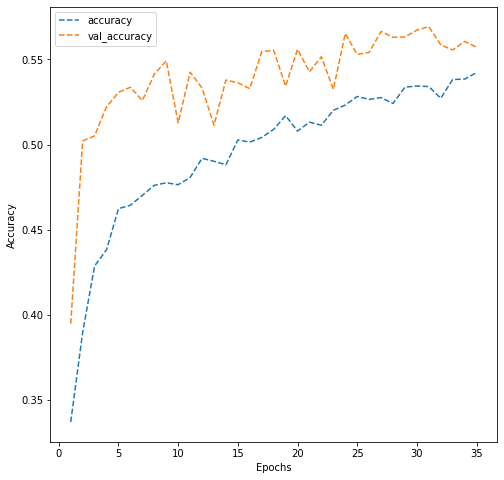

156/156 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

           0       0.66      0.56      0.61      1825
           1       0.48      0.49      0.49      1216
           2       0.44      0.55      0.49      1139
           3       0.68      0.66      0.67       797

    accuracy                           0.56      4977
   macro avg       0.57      0.57      0.56      4977
weighted avg       0.57      0.56      0.56      4977



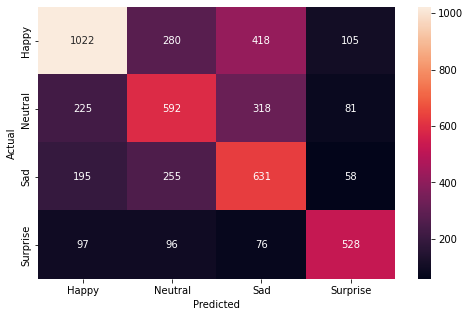

In [ ]:
# Ploting training information

dict_hist = history.history

ne=len(history.history['accuracy'])

list_ep = [i for i in range(1, ne+1)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, history.history['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, history.history['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

# Evaluating the model on the test data

validation_pred = np.argmax(vggmodel.predict(validation_set), axis = 1)

classes = ["Happy", "Neutral", "Sad", "Surprise"]

print(classification_report(validation_set.labels, validation_pred))
cm = confusion_matrix(validation_set.labels, validation_pred)
P_vgg=(cm.diagonal()/cm.sum(axis=1)).mean()

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = classes, yticklabels = classes)

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

## **ResNet V2 Model**

**Fixing the random seed to increase reproducibility**

In [16]:
np.random.seed(10)
random.seed(10)
tf.random.set_seed(10)

### **Importing the ResNet V2 Architecture**

In [17]:
Resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(48,48,3))
Resnet.summary()
print("\n The number of layers in ResNet V2 is: ",len(Resnet.layers))

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                          

In [18]:
transfer_layer_Resnet = Resnet.get_layer('conv2_block2_add')

Resnet.trainable=False

            
# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer_Resnet.output)

# Add a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

# Add a Dense Layer with 128 neurons
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)

# Add the final dense layer with 4 neurons and use a 'softmax' activation
pred = Dense(4, activation = 'softmax')(x)

resnetmodel = Model(Resnet.input, pred) # Initializing the model

### **Compiling and Training the Model**

In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Resnetmodel.h5", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True
                          )


reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.1,
                              patience = 2,
                              verbose = 1,
                              min_delta = 0.00001)


callbacks_list = [early_stopping, checkpoint, reduce_learningrate]


In [20]:
# Write your code to compile your resnetmodel. Use categorical crossentropy as your loss function, Adam Optimizer with 0.001 learning rate, and set your metrics to 'accuracy'. 
resnetmodel.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [21]:
# Write your code to fit your model. Use train_set as your training data and validation_set as your validation data. Train your model for 20 epochs.
history = resnetmodel.fit(train_set, epochs=10, validation_data= validation_set , callbacks=callbacks_list)

Epoch 1/10
473/473 [==============================] - ETA: 0s - loss: 1.5564 - accuracy: 0.2513

473/473 [==============================] - 21s 43ms/step - loss: 1.5564 - accuracy: 0.2513 - val_loss: 1.3551 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 2/10
472/473 [============================>.] - ETA: 0s - loss: 1.4296 - accuracy: 0.2520

473/473 [==============================] - 19s 41ms/step - loss: 1.4295 - accuracy: 0.2520 - val_loss: 1.3776 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 3/10
473/473 [==============================] - ETA: 0s - loss: 1.4035 - accuracy: 0.2544

473/473 [==============================] - 19s 41ms/step - loss: 1.4035 - accuracy: 0.2544 - val_loss: 1.3534 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 4/10
473/473 [==============================] - ETA: 0s - loss: 1.3933 - accuracy: 0.2570

473/473 [==============================] - 19s 41ms/step - loss: 1.3933 - accuracy: 0.2570 - val_loss: 1.3724 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 5/10
473/473 [==============================] - ETA: 0s - loss: 1.3901 - accuracy: 0.2585


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
473/473 [==============================] - 19s 40ms/step - loss: 1.3901 - accuracy: 0.2585 - val_loss: 1.3737 - val_accuracy: 0.2443 - lr: 0.0010
Epoch 6/10
473/473 [==============================] - ETA: 0s - loss: 1.3886 - accuracy: 0.2622

473/473 [==============================] - 20s 41ms/step - loss: 1.3886 - accuracy: 0.2622 - val_loss: 1.3699 - val_accuracy: 0.2475 - lr: 1.0000e-04
Epoch 7/10
472/473 [============================>.] - ETA: 0s - loss: 1.3876 - accuracy: 0.2569


Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
473/473 [==============================] - 20s 41ms/step - loss: 1.3877 - accuracy: 0.2568 - val_loss: 1.3683 - val_accuracy: 0.4035 - lr: 1.0000e-04
Epoch 8/10
473/473 [==============================] - ETA: 0s - loss: 1.3867 - accuracy: 0.2612

473/473 [==============================] - 19s 40ms/step - loss: 1.3867 - accuracy: 0.2612 - val_loss: 1.3682 - val_accuracy: 0.2443 - lr: 1.0000e-05
Epoch 9/10
472/473 [============================>.] - ETA: 0s - loss: 1.3863 - accuracy: 0.2600


Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
473/473 [==============================] - 19s 41ms/step - loss: 1.3863 - accuracy: 0.2600 - val_loss: 1.3678 - val_accuracy: 0.2443 - lr: 1.0000e-05
Epoch 10/10
472/473 [============================>.] - ETA: 0s - loss: 1.3841 - accuracy: 0.2654

473/473 [==============================] - 19s 41ms/step - loss: 1.3841 - accuracy: 0.2654 - val_loss: 1.3665 - val_accuracy: 0.2522 - lr: 1.0000e-06


### **Evaluating the ResNet Model**

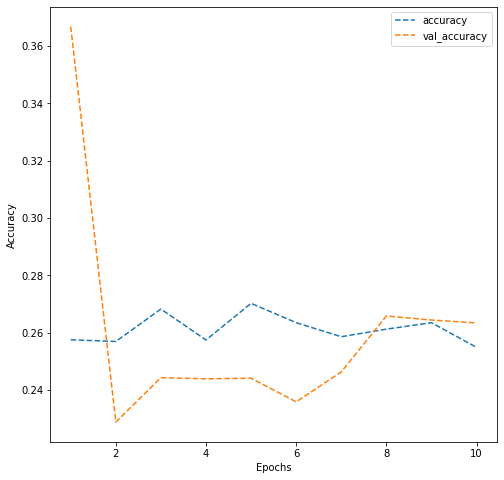

156/156 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1825
           1       0.27      0.45      0.34      1216
           2       0.26      0.67      0.37      1139
           3       0.00      0.00      0.00       797

    accuracy                           0.26      4977
   macro avg       0.13      0.28      0.18      4977
weighted avg       0.13      0.26      0.17      4977



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


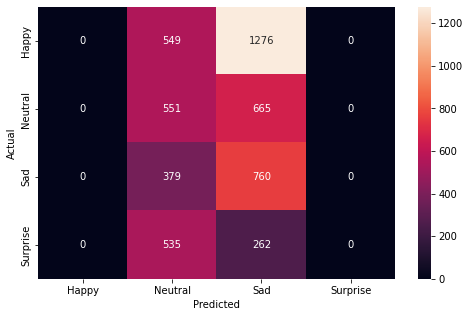

In [15]:
dict_hist = history.history

ne=len(history.history['accuracy'])

list_ep = [i for i in range(1, ne+1)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, history.history['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, history.history['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

# Evaluating the model on the test data

validation_pred = np.argmax(resnetmodel.predict(validation_set), axis = 1)

classes = ["Happy", "Neutral", "Sad", "Surprise"]

print(classification_report(validation_set.labels, validation_pred))
cm = confusion_matrix(validation_set.labels, validation_pred)
P_resnetmodel=(cm.diagonal()/cm.sum(axis=1)).mean()
plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = classes, yticklabels = classes)

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

## **EfficientNet Model**

**Fixing the random seed to increase reproducibility**

In [ ]:
np.random.seed(10)
random.seed(10)
tf.random.set_seed(10)

### **Importing the EfficientNet Architecture**

In [ ]:
EfficientNet = ap.EfficientNetV2B2(include_top=False,weights="imagenet", input_shape= (48, 48, 3))

EfficientNet.summary()

35839040/35839040 [==============================] - 2s 0us/step
Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_9[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 24, 24, 32)   864         ['normalization[0][0]']          
                 

### **Model Building**


In [ ]:
transfer_layer_EfficientNet = EfficientNet.get_layer('block4c_project_conv')
EfficientNet.trainable = False

# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer_EfficientNet.output)

# Add a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Add a Dense Layer with 128 neurons
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)


# Add the final dense layer with 4 neurons and use a 'softmax' activation
pred = Dense(4, activation = 'softmax')(x)

Efficientnetmodel = Model(EfficientNet.input, pred)

### **Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Efficientnetmodel.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True
                          )
reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.1,
                              patience = 2,
                              verbose = 1,
                              min_delta = 0.00001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]


In [ ]:
# Write your code to compile your Efficientnetmodel. Use categorical crossentropy as your loss function, Adam Optimizer with 0.001 learning rate, and set your metrics to 'accuracy'.
Efficientnetmodel.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Write your code to fit your model. Use train_set as your training data and validation_set as your validation data. Train your model for 20 epochs.
history = Efficientnetmodel.fit(train_set, epochs=10, validation_data= validation_set , callbacks=callbacks_list)

Epoch 1/10
473/473 [==============================] - ETA: 0s - loss: 1.6133 - accuracy: 0.2505

473/473 [==============================] - 26s 49ms/step - loss: 1.6133 - accuracy: 0.2505 - val_loss: 1.3738 - val_accuracy: 0.2443 - lr: 0.0010
Epoch 2/10
473/473 [==============================] - ETA: 0s - loss: 1.4208 - accuracy: 0.2662

473/473 [==============================] - 22s 46ms/step - loss: 1.4208 - accuracy: 0.2662 - val_loss: 1.3734 - val_accuracy: 0.2499 - lr: 0.0010
Epoch 3/10
472/473 [============================>.] - ETA: 0s - loss: 1.3967 - accuracy: 0.2576

473/473 [==============================] - 22s 47ms/step - loss: 1.3967 - accuracy: 0.2577 - val_loss: 1.3673 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 4/10
473/473 [==============================] - ETA: 0s - loss: 1.3876 - accuracy: 0.2644

473/473 [==============================] - 22s 46ms/step - loss: 1.3876 - accuracy: 0.2644 - val_loss: 1.3791 - val_accuracy: 0.2289 - lr: 0.0010
Epoch 5/10
473/473 [==============================] - ETA: 0s - loss: 1.3859 - accuracy: 0.2618


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
473/473 [==============================] - 22s 47ms/step - loss: 1.3859 - accuracy: 0.2618 - val_loss: 1.3686 - val_accuracy: 0.2664 - lr: 0.0010
Epoch 6/10
472/473 [============================>.] - ETA: 0s - loss: 1.3839 - accuracy: 0.2681

473/473 [==============================] - 22s 46ms/step - loss: 1.3839 - accuracy: 0.2680 - val_loss: 1.3718 - val_accuracy: 0.2680 - lr: 1.0000e-04
Epoch 7/10
473/473 [==============================] - ETA: 0s - loss: 1.3821 - accuracy: 0.2711

473/473 [==============================] - 22s 46ms/step - loss: 1.3821 - accuracy: 0.2711 - val_loss: 1.3630 - val_accuracy: 0.3223 - lr: 1.0000e-04
Epoch 8/10
473/473 [==============================] - ETA: 0s - loss: 1.3767 - accuracy: 0.2767

473/473 [==============================] - 22s 46ms/step - loss: 1.3767 - accuracy: 0.2767 - val_loss: 1.3495 - val_accuracy: 0.2936 - lr: 1.0000e-04
Epoch 9/10
473/473 [==============================] - ETA: 0s - loss: 1.3732 - accuracy: 0.2867

473/473 [==============================] - 22s 46ms/step - loss: 1.3732 - accuracy: 0.2867 - val_loss: 1.3478 - val_accuracy: 0.3048 - lr: 1.0000e-04
Epoch 10/10
472/473 [============================>.] - ETA: 0s - loss: 1.3659 - accuracy: 0.2996

473/473 [==============================] - 21s 45ms/step - loss: 1.3659 - accuracy: 0.2996 - val_loss: 1.3299 - val_accuracy: 0.3251 - lr: 1.0000e-04


### **Evaluating the EfficientnetNet Model**

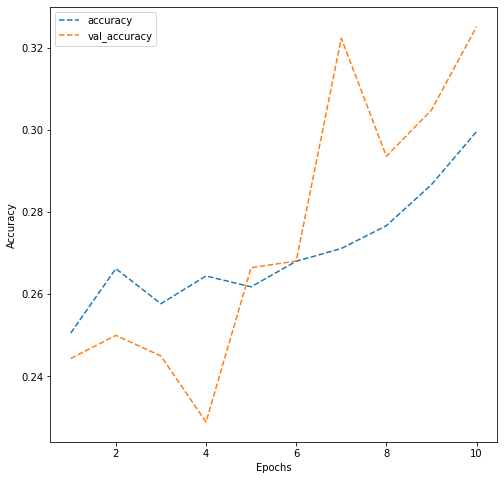

156/156 [==============================] - 3s 15ms/step
              precision    recall  f1-score   support

           0       0.39      0.16      0.23      1825
           1       0.29      0.80      0.42      1216
           2       0.29      0.13      0.18      1139
           3       0.62      0.27      0.38       797

    accuracy                           0.33      4977
   macro avg       0.40      0.34      0.30      4977
weighted avg       0.38      0.33      0.29      4977



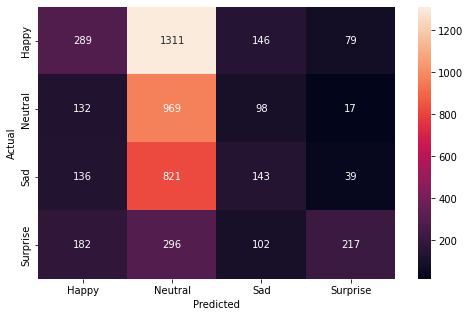

In [ ]:
dict_hist = history.history

ne=len(history.history['accuracy'])

list_ep = [i for i in range(1, ne+1)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, history.history['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, history.history['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

# Evaluating the model on the test data

validation_pred = np.argmax(Efficientnetmodel.predict(validation_set), axis = 1)

classes = ["Happy", "Neutral", "Sad", "Surprise"]

print(classification_report(validation_set.labels, validation_pred))
cm = confusion_matrix(validation_set.labels, validation_pred)
P_Efficientnetmodel=(cm.diagonal()/cm.sum(axis=1)).mean()

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = classes, yticklabels = classes)

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

### **Transfer Learning Summary and Conclusions**

In [ ]:
data = [["Model 1", P_model1], 
        ["Model 2", P_model2], 
        ["Model 3", P_model3],
        ["VGG16", P_vgg],
        ["ResNet V2", P_resnetmodel],
        ["EfficientNet", P_Efficientnetmodel],]
  
#define header names
col_names = ["Model", "Average Precision"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒══════════════╤═════════════════════╕
│ Model        │   Average Precision │
╞══════════════╪═════════════════════╡
│ Model 1      │            0.652389 │
├──────────────┼─────────────────────┤
│ Model 2      │            0.694822 │
├──────────────┼─────────────────────┤
│ Model 3      │            0.730059 │
├──────────────┼─────────────────────┤
│ VGG16        │            0.56583  │
├──────────────┼─────────────────────┤
│ ResNet V2    │            0.25     │
├──────────────┼─────────────────────┤
│ EfficientNet │            0.338263 │
╘══════════════╧═════════════════════╛


### **Conclusions**



1.   Up to this point, we've evaluated 3 models + 3 transfer learning models with the best accuracy of 73% for model 3.
2.   Transfer learning didn't seem to be much helpful. The accuracies are consistently lower than all of the trained models 1-3.
3.   Using transfer learning, VGG16 did a better job classifying the photos. The other two either failed to classify photos or performed poorly on the data.
4.  One thing to consider is that the transferred models were trained on RGB images while our data is in graystyle.
5.  Additionally, the transferred models were trained on the Imagenet dataset. Therefore the network was trained for identifying photos that are not relevant to our problem. (Facial emotions aren't in Imagenet classes)
6. Among the transferred models, VGG 16 seemed more promising than the other two. 
7. We'll try to implement fine-tuning to VGG16 and see if we can improve the performance.
<hr>

### **Further Improvement**
In general, the first layers of the convolutional networks are responsible for detecting generic features like edges and shapes, and as you go deeper into the network, they become more and more specific to the features of the images they were trained on.<br>
Therefore, an alternative approach is to only fix the first few layers of a transfer learning model and retrain the rest. This is called **fine-tuning**. 

### **VGG16 + Fine-Tuning**

* In this model, we will import till the **'block5_pool'** layer of the VGG16 model. Here we'll try to improve the performance of the VGG16 model by adding the first 11 layers and retraining the rest of the convolutional layers.


**Fixing the random seed to increase reproducibility**

In [ ]:
np.random.seed(10)
random.seed(10)
tf.random.set_seed(10)

### **Importing the VGG16 Architecture**

In [ ]:
vgg_ft = VGG16(include_top = False, weights = 'imagenet', input_shape = (48, 48, 3))
vgg_ft.summary()
print("\n The number of layers in VGG16_ft is: ",len(vgg_ft.layers))

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
transfer_layer = vgg_ft.get_layer('block5_pool')
fine_tune=11

if fine_tune > 0:
        for layer in vgg_ft.layers[:-fine_tune]:
            layer.trainable = False
else:
        for layer in vgg_ft.layers:
            layer.trainable = False


# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer.output)

# Adding a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Batch Normalization layer

x = BatchNormalization()(x)
# Adding the final dense layer with 4 neurons and use 'softmax' activation
pred = Dense(4, activation='softmax')(x)

vggmodel_ft = Model(vgg_ft.input, pred) # Initializing the model

### **Compiling and Training the VGG16 + FT**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./vggmodel_ft.h5", monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.5,
                              patience = 5,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [ ]:
# Write your code to compile the vggmodel. Use categorical crossentropy as the loss function, Adam Optimizer with 0.001 learning rate, and set metrics to 'accuracy'. 
vggmodel_ft.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Write your code to fit your model. Use train_set as the training data and validation_set as the validation data. Train the model for 20 epochs.
history = vggmodel_ft.fit(train_set, epochs=35, validation_data= validation_set , callbacks=callbacks_list)

Epoch 1/35
472/473 [============================>.] - ETA: 0s - loss: 1.4326 - accuracy: 0.2999
Epoch 1: val_loss improved from -inf to 1.28283, saving model to ./vggmodel_ft.h5
473/473 [==============================] - 25s 52ms/step - loss: 1.4326 - accuracy: 0.2997 - val_loss: 1.2828 - val_accuracy: 0.4051 - lr: 0.0010
Epoch 2/35
472/473 [============================>.] - ETA: 0s - loss: 1.1943 - accuracy: 0.3980
Epoch 2: val_loss did not improve from 1.28283
473/473 [==============================] - 24s 50ms/step - loss: 1.1943 - accuracy: 0.3982 - val_loss: 1.1340 - val_accuracy: 0.4736 - lr: 0.0010
Epoch 3/35
472/473 [============================>.] - ETA: 0s - loss: 1.1239 - accuracy: 0.4563
Epoch 3: val_loss did not improve from 1.28283
473/473 [==============================] - 24s 51ms/step - loss: 1.1239 - accuracy: 0.4564 - val_loss: 1.0299 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 4/35
473/473 [==============================] - ETA: 0s - loss: 1.1022 - accuracy: 0.4826
Ep

### **Evaluating the VGG16 + FT model**

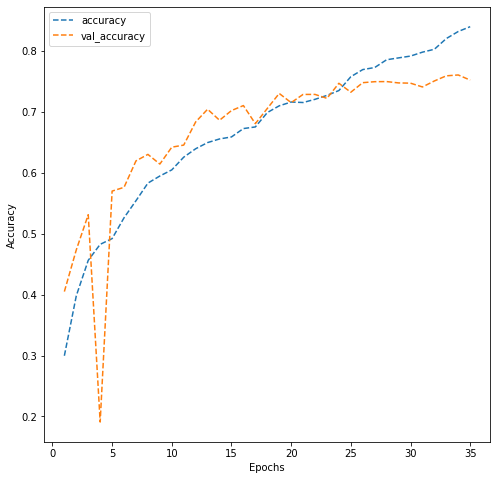

156/156 [==============================] - 2s 14ms/step
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1825
           1       0.66      0.60      0.63      1216
           2       0.62      0.71      0.66      1139
           3       0.82      0.86      0.84       797

    accuracy                           0.75      4977
   macro avg       0.74      0.75      0.75      4977
weighted avg       0.76      0.75      0.75      4977



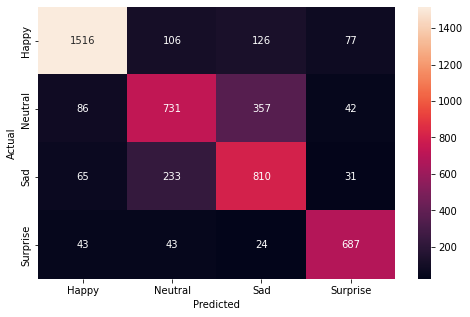

In [ ]:
# Ploting training information

dict_hist = history.history

ne=len(history.history['accuracy'])

list_ep = [i for i in range(1, ne+1)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, history.history['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, history.history['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

# Evaluating the model on the test data

validation_pred = np.argmax(vggmodel_ft.predict(validation_set), axis = 1)

classes = ["Happy", "Neutral", "Sad", "Surprise"]

print(classification_report(validation_set.labels, validation_pred))
cm = confusion_matrix(validation_set.labels, validation_pred)
P_vggmodel_ft=(cm.diagonal()/cm.sum(axis=1)).mean()

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = classes, yticklabels = classes)

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

### **All Models Summary and Conclusions**

In [ ]:
data = [["Model 1", P_model1], 
        ["Model 2", P_model2], 
        ["Model 3", P_model3],
        ["VGG16", P_vgg],
        ["ResNet V2", P_resnetmodel],
        ["EfficientNet", P_Efficientnetmodel],
        ["VGG16 + Fine-Tuning", P_vggmodel_ft]]
  
#define header names
col_names = ["Model", "Average Precision"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═════════════════════╤═════════════════════╕
│ Model               │   Average Precision │
╞═════════════════════╪═════════════════════╡
│ Model 1             │            0.652389 │
├─────────────────────┼─────────────────────┤
│ Model 2             │            0.694822 │
├─────────────────────┼─────────────────────┤
│ Model 3             │            0.730059 │
├─────────────────────┼─────────────────────┤
│ VGG16               │            0.56583  │
├─────────────────────┼─────────────────────┤
│ ResNet V2           │            0.25     │
├─────────────────────┼─────────────────────┤
│ EfficientNet        │            0.338263 │
├─────────────────────┼─────────────────────┤
│ VGG16 + Fine-Tuning │            0.751242 │
╘═════════════════════╧═════════════════════╛


### **Conclusions**



1.   A summary of the performance of differnt models on the validation set is presented in the table above.
2.   Among these models, Model 3 and VGG16 + Fine-tuning have above 70% accuracy. 
3.  VGG16 + Fine-Tuning with an accuracy of 75% has the highest  precision among all the presented models.
4.  In all cases, most of the misclassifications are between sad and neutral. Some photos in these two categories are so similar that it's even hard for human eyes to correctly classify them. 
<hr>

### **Plotting the Confusion Matrix for the chosen final model**

4/4 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        32
           1       0.73      0.69      0.71        32
           2       0.68      0.78      0.72        32
           3       0.97      0.88      0.92        32

    accuracy                           0.80       128
   macro avg       0.80      0.80      0.80       128
weighted avg       0.80      0.80      0.80       128



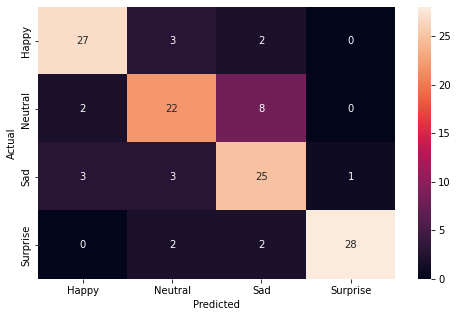

In [ ]:
# Plot the confusion matrix and generate a classification report for the model

test_pred = np.argmax(vggmodel_ft.predict(test_set), axis = 1)

classes = ["Happy", "Neutral", "Sad", "Surprise"]

print(classification_report(test_set.labels, test_pred))
cm = confusion_matrix(test_set.labels, test_pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = classes, yticklabels = classes)

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

### **Overall conclusions**



1.   The test set was an unseen set of data that was never used to train, optimize or select the best model.
2.   Fine-tuned VGG16 was selected as the best model as it performed much better than all other models on validation data. 
3.   The selected model had an accuracy of 80% on the test data.
4.   We saw that some categories like "surprise" and "happy" have distinctive features that make them easy to tell apart. However, the other two categories ("sad" and "surprise") share similar features that make them extremely difficult to be distinguished even for human intelligence let alone machine.
4.   The goodness of a model can be subjective and it's hard to set an acceptable threshold for accuracy. For instance, the quality and quantity of the data can play an important role in the overall accuracy of the model.
5. In this case, the similarity of the two categories made it difficult for the model to distinguish between them. Therefore, it's reasonable to assume that an accuracy of 80% is close to the high end of the performance for this problem. 

